In [10]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load data as dataframe
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [4]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

# first sort by category id, then sort by date
df1.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_success.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_fail.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)


In [5]:
# write to csv file
df1.to_csv(path2 + "/All.csv", index = False) # 7722
df1_success.to_csv(path2 + "/All_Success.csv", index = False) # 5348
df1_fail.to_csv(path2 + "/All_Fail.csv", index = False)# 2374

# 7722 unique projects that were not cancelled in US with at least $25,000 goal 
# and $2500 pledged from 10/4/2009 - 12/12/2018
# 5348 unique successes
# 2374 unique failures

In [6]:
### CALCULATION - PROBABILITY OF SUCCESS

# probability of success per category
category_multi_projects = []
category_success_rate = {}
category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
# creating list of categories with more than one project
for i in category_freq:
    if category_freq[i] > 1:
        category_multi_projects.append(i)
for j in category_freq:
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0
    
# probability of success for aggregate categories
success_rate = len(df1_success) / len(df1)
print("Probability of success:")
print(success_rate)

Probability of success:
0.6925666925666926


In [7]:
##### CATEGORIES RESEARCH

In [8]:
### COMPETITION VS. NON-COMPETITION

df2 = df1.copy() # >1 project per category
df2_1 = df1.copy() # 1 project per category

category_single_projects = []
for i in category_freq:
    if category_freq[i] == 1:
        category_single_projects.append(i)
df2 = df2.loc[df2['category_name'].isin(category_multi_projects)]
df2_1 = df2_1.loc[df2_1['category_name'].isin(category_single_projects)]

df3 = pd.DataFrame()
df3_1 = pd.DataFrame()
count = 0
for j in category_multi_projects:
    temp = df2.loc[df2['category_name'] == j]
    temp['overlap'] = (temp['deadline'].shift() - temp['created_at']) > timedelta(0)
    temp1 = temp.loc[temp['overlap'] == True]
    temp2 = temp.loc[temp['overlap'] == False]
    temp1.drop(['overlap'], inplace = True, axis = 1)
    temp2.drop(['overlap'], inplace = True, axis = 1)
    if len(temp1) > 0:
        df3 = df3.append(temp1) # overlapping projects within category
    if len(temp2) > 0:
        df3_1 = df3_1.append(temp2) # non-overlapping projects within category
                 
df3_1 = df3_1.append(df2_1) # single + non-overlapping projects
            
df3_success = df3.loc[df3['state'] == 'successful'] # successful subset for competing projects
df3_fail = df3.loc[df3['state'] == 'failed'] # failed subset for competing projects
df3_1_success = df3_1.loc[df3_1['state'] == 'successful'] # successful subset for non-competing projects
df3_1_fail = df3_1.loc[df3_1['state'] == 'failed'] # failed subset for non-competing projects

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# write to csv file
# projects in the same category with overlapping time series
df3.to_csv(path2 + "/All_Competition.csv", index = False) # 6615
df3_success.to_csv(path2 + "/Success_Competition.csv", index = False) # 4578
df3_fail.to_csv(path2 + "/Fail_Competition.csv", index = False) # 2037
df3_1.to_csv(path2 + "/All_Non_Competition.csv", index = False) # 1107
df3_1_success.to_csv(path2 + "/Success_Non_Competition.csv", index = False) # 770
df3_1_fail.to_csv(path2 + "/Fail_Non_Competition.csv", index = False) # 337

# 6615 projects in the same category with overlapping time series
# 4578 of these projects were successful
# 2037 of these projects failed

# 1107 projects had no competition
# 770 of these projects were successful
# 337 of these projects failed

In [11]:
print(len(df3))

6615


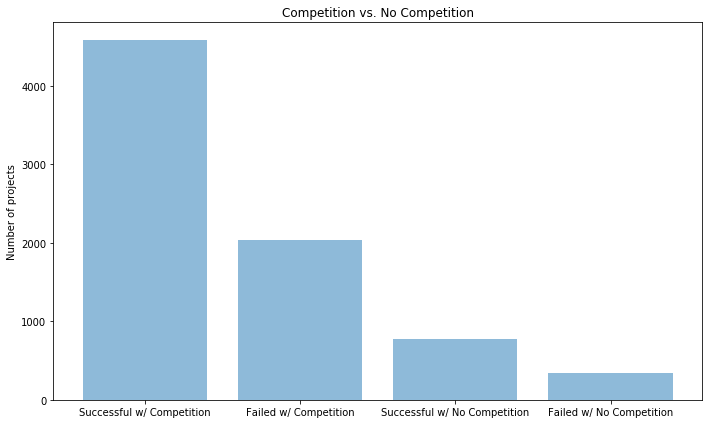

In [17]:
objects = ('Successful w/ Competition', 'Failed w/ Competition', 
           'Successful w/ No Competition', 'Failed w/ No Competition',)
y_pos = np.arange(len(objects))
performance = [len(df3_success), len(df3_fail), len(df3_1_success), len(df3_1_fail)]

fig = plt.figure(figsize=(10, 6))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of projects')
plt.title('Competition vs. No Competition')

plt.tight_layout()

plt.show()

In [18]:
competition_category_success_rate = {}
competition_category_freq = df3['category_name'].value_counts().to_dict()
competition_category_success_freq = df3_success['category_name'].value_counts().to_dict()
competition_category_fail_freq = df3_fail['category_name'].value_counts().to_dict()

non_competition_category_success_rate = {}
non_competition_category_freq = df3_1['category_name'].value_counts().to_dict()
non_competition_category_success_freq = df3_1_success['category_name'].value_counts().to_dict()
non_competition_category_fail_freq = df3_1_fail['category_name'].value_counts().to_dict()

In [19]:
### CALCULATION - NUMBER OF PROJECTS PER CATEGORY

# all
category_num = dict()
for k, v in category_freq.items():
    category_num[k] = [v]

# all success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_num[k].append(category_success_freq[k])
    else: # no successes in these categories
        category_num[k].append(0)
# all fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_num[k].append(category_fail_freq[k])
    else:
        category_num[k].append(0)

#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_num[k].append(competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_num[k].append(competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_num[k].append(competition_category_fail_freq[k])
    else:
        category_num[k].append(0)
        
#-------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_num[k].append(non_competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_num[k].append(non_competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_num[k].append(non_competition_category_fail_freq[k])
    else:
        category_num[k].append(0)

# ------------------
        
# Write calculations to csv files

df7 = pd.DataFrame(category_num.items(), columns = ['category_name', 'number'])
with open(path2 + "/Number_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df7['number'])):
        lst1 = list(df7['number'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']: # > 0 competing projects
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [53]:
labels = []
all_num = []
for i in range(len(df7['number'])):
    labels.append(df7['number'][i][0])
    all_num.append(df7['number'][i][1])

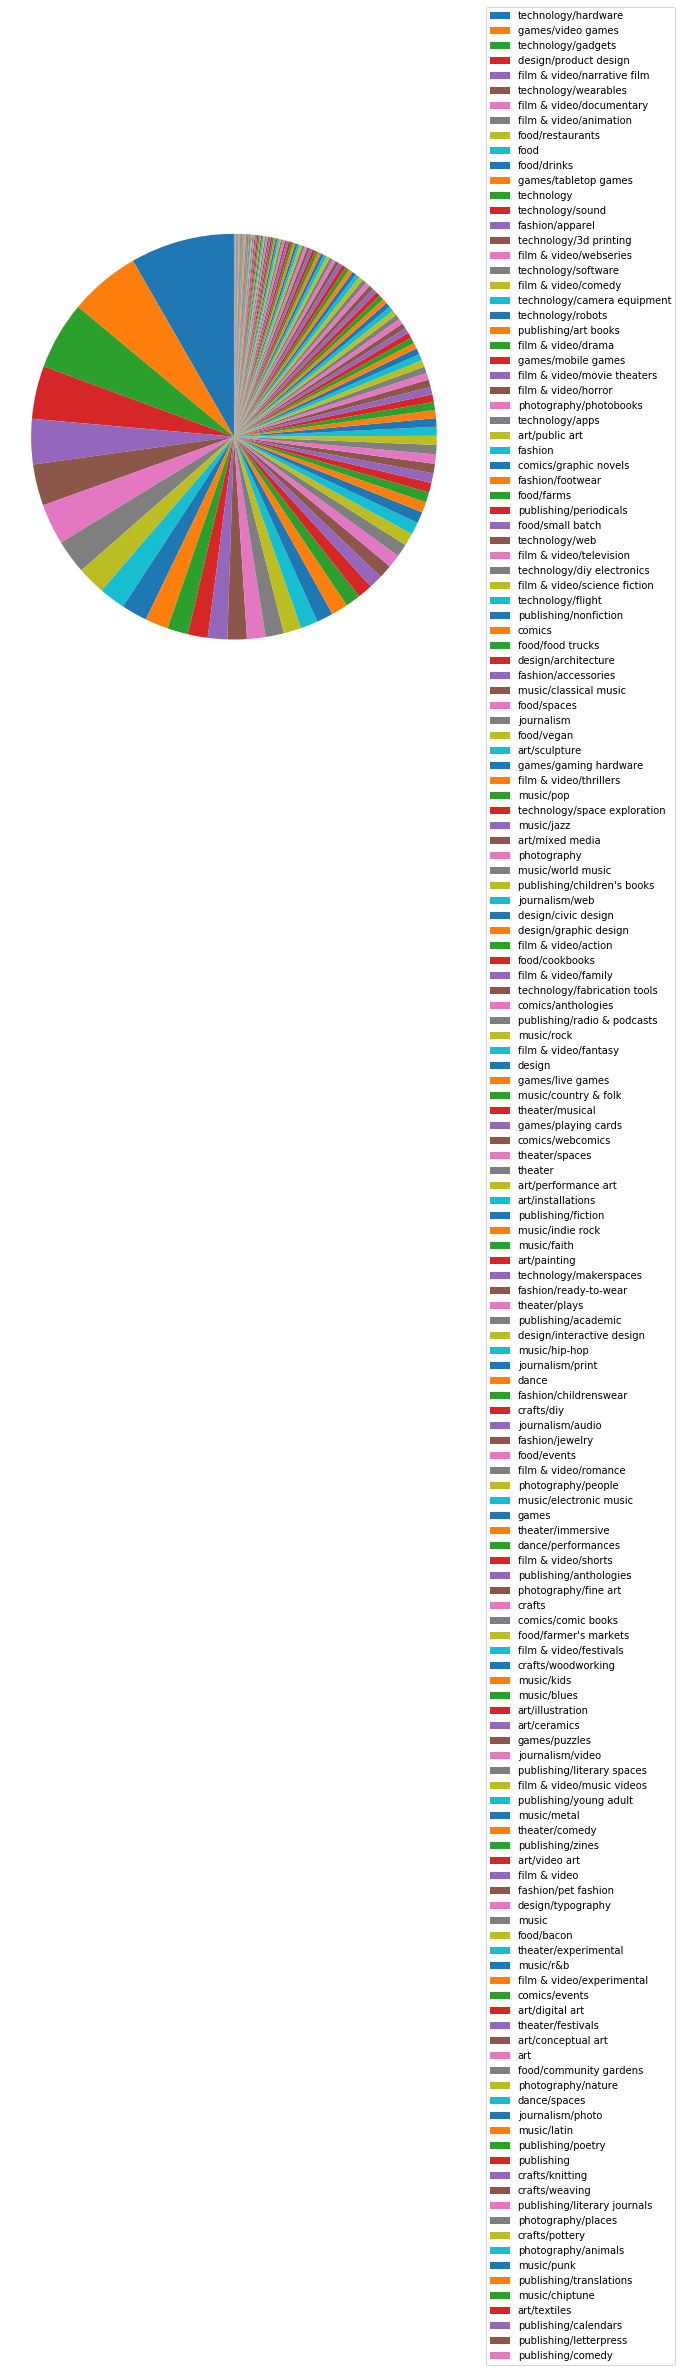

<Figure size 432x288 with 0 Axes>

In [55]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(8, 8))
patches, texts = plt.pie(all_num, startangle=90)
plt.legend(patches, labels, loc="upper right", bbox_to_anchor=(1.5, 1.5))
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.savefig(path3 + 'Categories_number_of_projects.png')

In [20]:
### CALCULATION - PROPORTION PER CATEGORY

# all
category_frac = dict()
for k, v in category_freq.items():
    category_frac[k] = [v / len(df1)]

# success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_frac[k].append(category_success_freq[k] / len(df1_success))
    else: # no successes in these categories
        category_frac[k].append(0)
# fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_frac[k].append(category_fail_freq[k] / len(df1_fail))
    else:
        category_frac[k].append(0)
        
#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_frac[k].append(competition_category_freq[k] / len(df3))
    else:
        category_frac[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_frac[k].append(competition_category_success_freq[k] / len(df3_success))
    else:
        category_frac[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_frac[k].append(competition_category_fail_freq[k] / len(df3_fail))
    else:
        category_frac[k].append(0)
        
# ------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_frac[k].append(non_competition_category_freq[k] / len(df3_1))
    else:
        category_frac[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_frac[k].append(non_competition_category_success_freq[k] / len(df3_1_success))
    else:
        category_frac[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_frac[k].append(non_competition_category_fail_freq[k] / len(df3_1_fail))
    else:
        category_frac[k].append(0)

# ------------------
        
# Write calculations to csv files

df8 = pd.DataFrame(category_frac.items(), columns = ['category_name', 'proportion'])
with open(path2 + "/Proportion_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df8['proportion'])):
        lst1 = list(df8['proportion'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [21]:
### CALCULATION - PROBABILITY OF SUCCESS PER CATEGORY

# probability of success per category conditional on competition

# creating list of categories with overlapping projects
for i in category_freq:
    if i in category_multi_projects:
        if i in competition_category_success_freq.keys():
            competition_category_success_rate[i] = competition_category_success_freq[i] / competition_category_freq[i]
        else:
            competition_category_success_rate[i] = 0
    else:
        competition_category_success_rate[i] = 0
    
# probability of success for aggregate categories conditional on competition
competition_success_rate = len(df3_success) / len(df3)
print("Probability of success conditional on competition:")
print(competition_success_rate)

# --------------

# probability of success per category conditional on no competition

# creating list of categories without overlapping projects
for i in category_freq:
    if i in category_single_projects or i in category_multi_projects:
        if i in non_competition_category_success_freq.keys():
            non_competition_category_success_rate[i] = non_competition_category_success_freq[i] / non_competition_category_freq[i]
        else:  # no successes in these categories
            non_competition_category_success_rate[i] = 0
    else:
        non_competition_category_success_rate[i] = 0
    
# probability of success for aggregate categories conditional on competition
non_competition_success_rate = len(df3_1_success) / len(df3_1)
print("Probability of success conditional on non-competition:")
print(non_competition_success_rate)

# --------------

# Write calculations to csv files

subsets = [category_success_rate, competition_category_success_rate, non_competition_category_success_rate]

prob_success = {}
for k in category_success_rate.keys():
    prob_success[k] = list(str(prob_success[k]) for prob_success in subsets)

df9 = pd.DataFrame(prob_success.items(), columns = ['category_name', 'prob_of_success'])
count_compete = 0
count_non_compete = 0
with open(path2 + "/Prob_Of_Success_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Competition','Non-Competition', 'Difference'])
    lst2 = list(category_freq.keys())
    for i in range(len(df9['prob_of_success'])):
        lst = list(df9['prob_of_success'])[i]
        lst1 = [ '%.4f' % float(j) for j in lst]
        if lst1[1] not in ['1.0000','1','0.0000','0'] and lst1[2] not in ['1.0000','1','0.0000','0']: # > 0 competing/non-competing projects
            lst1.insert(0, str(lst2[i]))
            diff = round(float(lst1[2]) - float(lst1[3]),4)
            lst1.insert(len(lst1),str(diff))
            if diff > 0:
                count_compete += 1
            else:
                count_non_compete += 1
            writer.writerow(lst1)

print("Prob of success competition > non-competition for the following percentage of categories: ")
print("{:.2%}".format(count_compete / (count_compete + count_non_compete)))

# Probability of success:
# 0.6925666925666926

Probability of success conditional on competition:
0.692063492063492
Probability of success conditional on non-competition:
0.6955736224028907
Prob of success competition > non-competition for the following percentage of categories: 
35.14%
